# Notebook to generate hyperparameter sweep plot

This notebook requires the modeling hyperparameter results data, saved in
`../../cache/phys_modeling_logs/main_hyperparams`. This can be downloaded from
the OSF repo or can be generated by running your own hyperparameter sweep.

In [58]:
"""Imports."""

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import json
import seaborn as sns

# Matplotlib settings
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['figure.dpi'] = 300

In [59]:
"""Load data."""

DATA_DIR = Path("../../cache/modeling/hyperparams")
MODELS = [
    "triangle_slot_partition_v2",
    "triangle_switching_v2",
    "triangle_gain_v1",
]
SUBJECT = "Perle"
# SESSION = "2022-05-31"
SESSION = "2022-06-01"

# MODELS = [
#     "ring_slots",
#     "ring_switching",
#     "ring_gain",
# ]
# MODELS = [
#     "ring_slots_4bins",
#     "ring_switching_4bins",
#     "ring_gain_4bins",
# ]
# MODELS = [
#     "ring_slots_4bins_0002_lr_per_trial",
#     "ring_switching_4bins_0002_lr_per_trial",
#     "ring_gain_4bins_0002_lr_per_trial",
# ]
# SUBJECT = "Elgar"
# SESSION = "2022-09-09"

# Load the data
df_dict = {
    "model": [],
    "seed": [],
    "smoothness": [],
    "step": [],
    "log_likelihood": [],
}
for model in MODELS:
    data_dir = DATA_DIR / model / SUBJECT / SESSION
    for seed_dir in data_dir.iterdir():
        if not seed_dir.is_dir():
            continue
        seed = int(seed_dir.name)
        for smoothness_dir in seed_dir.iterdir():
            smoothness = float(smoothness_dir.name)
            test_metrics_path = smoothness_dir / "test_metrics.json"
            if not test_metrics_path.exists():
                continue
            test_metrics = json.load(open(smoothness_dir / "test_metrics.json"))
            for step_dict in test_metrics:
                df_dict["model"].append(model)
                df_dict["seed"].append(seed)
                df_dict["smoothness"].append(smoothness)
                df_dict["step"].append(step_dict["step"])
                df_dict["log_likelihood"].append(step_dict["mean_log_likelihood"])

df = pd.DataFrame(df_dict)

<>:35: SyntaxWarning: invalid escape sequence '\k'
<>:35: SyntaxWarning: invalid escape sequence '\k'
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_12892/4040849488.py:35: SyntaxWarning: invalid escape sequence '\k'
  ax.set_ylabel('Smoothness $\kappa$ (s)')
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_12892/4040849488.py:63: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


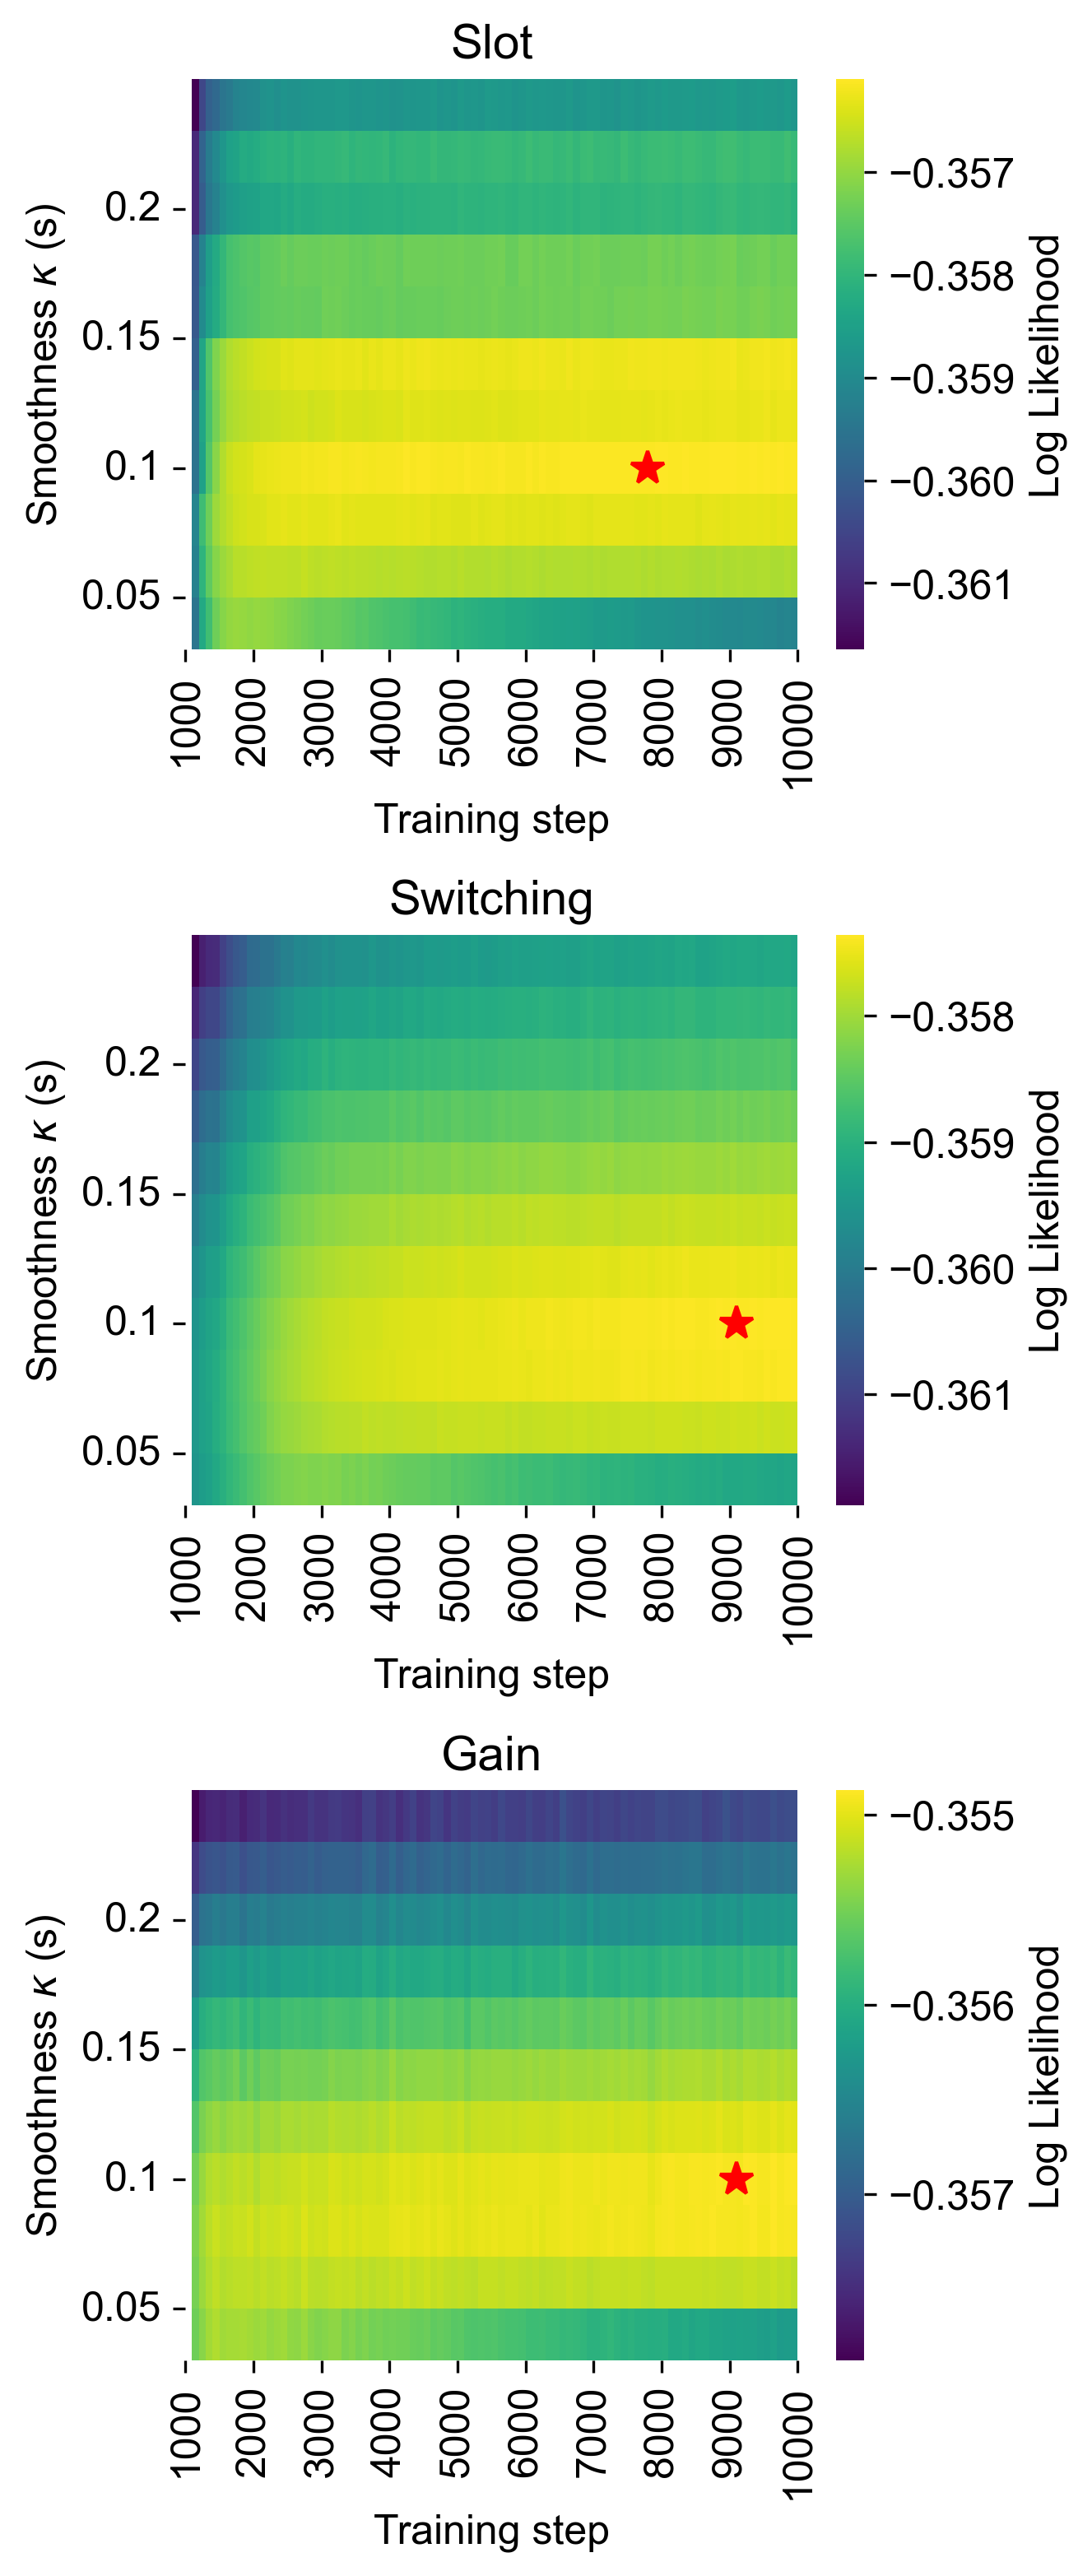

In [62]:
"""Heatmap of log likelihood."""

step_burn_in = 1000
df_plot = df[df.step > step_burn_in]

# Heatmap of log likelihood over smoothness and step for each model
fig, axes = plt.subplots(3, 1, figsize=(4, 12), gridspec_kw={'hspace': 0.5}, sharex=False, sharey=False)
for ax, model in zip(axes, MODELS):
    df_model = df_plot[df_plot['model'] == model]
    
    # Find the smoothness and step values for the maximum log likelihood
    max_log_likelihood = df_model['log_likelihood'].max()
    max_row = df_model[df_model['log_likelihood'] == max_log_likelihood].iloc[0]
    max_smoothness = max_row['smoothness']
    max_step = max_row['step']

    # Create heatmap
    heatmap_data = df_model.pivot_table(
        index='smoothness',
        columns='step',
        values='log_likelihood',
        aggfunc='mean',
    ).sort_index(ascending=False).sort_index(axis=1)
    sns.heatmap(
        heatmap_data,
        cmap='viridis',
        ax=ax,
        cbar_kws={'label': 'Log Likelihood'},
    )
    model_name = model.split("_")[1].capitalize()
    if model_name == "Slots":
        model_name = "Slot"
    ax.set_title(model_name)
    ax.set_xlabel('Training step')
    ax.set_ylabel('Smoothness $\kappa$ (s)')
    
    # Add a star marker for the maximum log likelihood
    star_x = (max_step - step_burn_in) // 100 - 2
    star_y = 10.5 - (max_smoothness * 50)
    ax.plot(star_x, star_y, 'r*', markersize=10)
    
    # Make the x-axis ticks more readable
    x_values = heatmap_data.columns.values
    extent_x = (np.min(x_values), np.max(x_values))
    x_steps = len(heatmap_data.columns)
    y_values = heatmap_data.index.values
    extent_y = (np.min(y_values), np.max(y_values))
    y_steps = len(heatmap_data.index)

    # Make the x-axis ticks go from 1000 to 5000 in steps of 1000
    x_ticklabels = np.arange(1000, 10001, 1000)
    x_ticks = (x_ticklabels - extent_x[0]) / (extent_x[1] - extent_x[0]) * (x_steps - 1)
    ax.set_xticks(x_ticks)
    ax.set_xticklabels(x_ticklabels)
    
    # # Make the y-axis ticks go from 0.0 to 0.2 in steps of 0.05
    y_ticklabels = np.arange(0.2, 0.0, -0.05).round(2)
    y_ticks = (y_ticklabels - extent_y[0]) / (extent_y[1] - extent_y[0]) * (y_steps - 1)
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(y_ticklabels[::-1])
    
# Save figure
fig.tight_layout()
fig.savefig("plots/heatmaps.pdf", bbox_inches='tight', pad_inches=0.01)

<>:37: SyntaxWarning: invalid escape sequence '\k'
<>:37: SyntaxWarning: invalid escape sequence '\k'
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_12892/4191988103.py:37: SyntaxWarning: invalid escape sequence '\k'
  ax.set_xlabel('Smoothness $\kappa$ (s)')
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_12892/4191988103.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  best_step_ll = df_model.groupby(['smoothness', 'seed']).apply(
/var/folders/_h/nj1cpgkx7yl40q0b31fq3swr0000gn/T/ipykernel_12892/4191988103.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be e

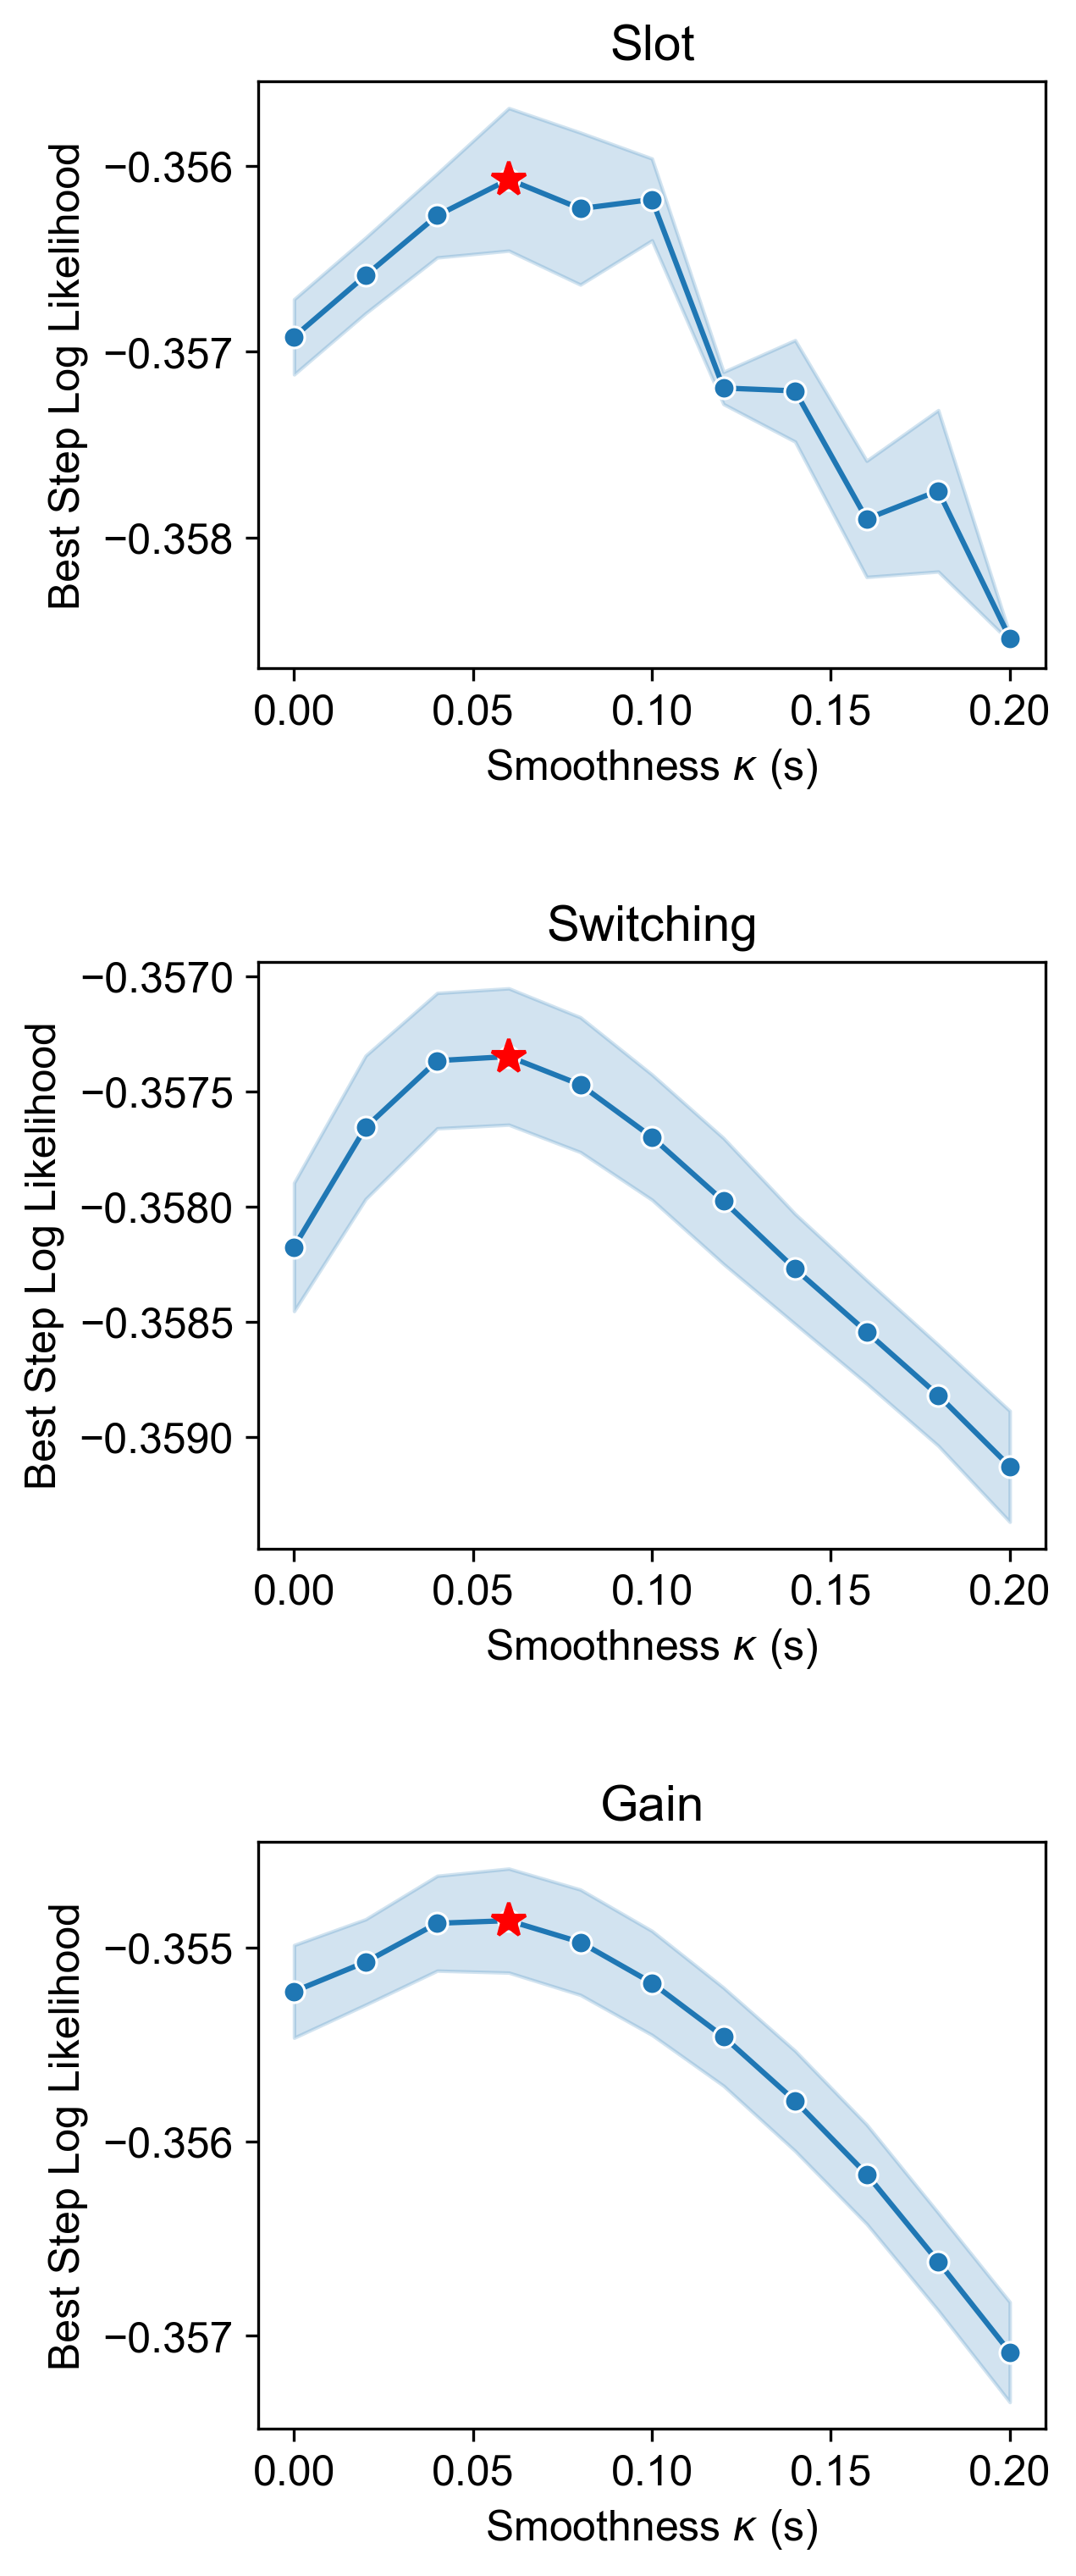

In [61]:
"""Lineplot of best-step log likelihood."""

fig, axes = plt.subplots(3, 1, figsize=(4, 12), gridspec_kw={'hspace': 0.5}, sharex=False, sharey=False)
for ax, model in zip(axes, MODELS):
    df_model = df_plot[df_plot['model'] == model]
    
    # Do the same thing but also keep the log likelihood
    best_step_ll = df_model.groupby(['smoothness', 'seed']).apply(
        lambda x: x.loc[x['log_likelihood'].idxmax(), ['step', 'log_likelihood']]
    ).reset_index()
    
    # Lineplot of best step log likelihood
    sns.lineplot(
        data=best_step_ll,
        x='smoothness',
        y='log_likelihood',
        ax=ax,
        marker='o',
    )
    
    # Add a star marker for the maximum log likelihood
    # Take average over seeds
    mean_best_step_ll = best_step_ll.groupby('smoothness').mean().reset_index()
    maximum_mean_ll_step = mean_best_step_ll['log_likelihood'].idxmax()
    maximum_mean_ll = mean_best_step_ll['log_likelihood'].max()
    ax.plot(
        mean_best_step_ll['smoothness'][maximum_mean_ll_step],
        maximum_mean_ll,
        'r*',
        markersize=10,
    )

    model_name = model.split("_")[1].capitalize()
    if model_name == "Slots":
        model_name = "Slot"
    ax.set_title(model_name)
    ax.set_xlabel('Smoothness $\kappa$ (s)')
    ax.set_ylabel('Best Step Log Likelihood')
    
# Save figure
fig.tight_layout()
fig.savefig("plots/lineplots.pdf", bbox_inches='tight', pad_inches=0.01)